# Small and shallow networks

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
import tensorflow as tf

# Use GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import tensorflow_probability as tfp
import keras as keras
import pandas as pd
import pystan
import scipy.stats as stats
import scipy.signal
import seaborn as sns
import tqdm
import datetime
import sys
import ctypes
import pickle
from keras import backend as K
from keras.layers import Layer
from keras.layers import Input
from keras.models import Model
from keras import callbacks, optimizers
from IPython.display import display, clear_output, HTML
from numpy import trapz
from scipy.stats import norm

sys.path.append('../')
import src.vimlts_utils_keras as VIMLTS_utils
from src.vimlts import VIMLTS
from src.vigauss_keras import DenseVIGAUSS
from src.vimlts_keras import DenseVIMLTS

tfd=tfp.distributions

print('Tensorflow version: ',tf.__version__, )

Using TensorFlow backend.
Tensorflow version:  2.1.0


## Data generating process

In [2]:
def get_toy_data_3(
    noise_scale,
    train_size,
    test_size,
    true_size,
    use_hole
):
    tf.random.set_seed(2)

    train_xlim = 6.
    test_xlim = 6.5
    true_xlim = 6.5

    # True function
    target_fn = lambda x: np.sin(x)

    # Train samples
    if use_hole:
        half_train_size = train_size // 2
        train_xs_left = tfd.Uniform(low = -train_xlim, high = -train_xlim/3).sample(sample_shape = (half_train_size, 1))
        train_xs_right = tfd.Uniform(low = train_xlim/3, high = train_xlim).sample(sample_shape = (half_train_size, 1))
        train_xs = np.concatenate((train_xs_left, train_xs_right))
    else:
        train_xs = np.linspace(-train_xlim,train_xlim,train_size)
        train_xs = np.reshape(train_xs,[-1,1])


    train_ys = target_fn(train_xs)
    train_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (train_size, 1))

    # Test samples
    test_xs = np.linspace(-test_xlim,test_xlim,test_size)
    test_xs = np.reshape(test_xs,[-1,1])
    test_ys = target_fn(test_xs)
    test_ys += noise_scale * tfd.Normal(loc=0.,scale=1.).sample(sample_shape = (test_size, 1))

    # True
    true_xs = np.linspace(-true_xlim, true_xlim, true_size)
    true_xs = np.reshape(true_xs, (true_size, 1))
    true_ys = target_fn(true_xs)


    return train_xs, train_ys, test_xs, test_ys, true_xs, true_ys

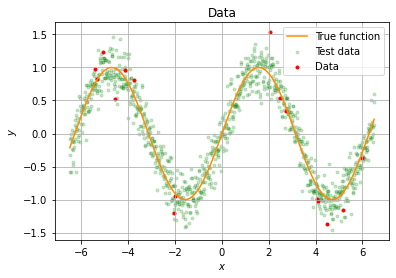

In [3]:
sigma = noise  = .2
num = train_size = 16
test_size = 1000
true_size = 1000

x, y, x_test, y_test, x_true, y_true = get_toy_data_3(sigma, train_size, test_size, true_size,use_hole=1)
y=np.reshape(y,[-1])
y_test=np.reshape(y_test,[-1])

plt.figure()
plt.scatter(x_test,y_test, marker='.', color='g',label=r"Test data",alpha=0.2)
plt.scatter(x,y, marker='.', color='r',label=r"Data")
plt.plot(x_true,y_true,color="darkorange",label=r"True function")
plt.grid()
plt.legend()
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")
plt.title(r'Data');

## Common hyperparameter

In [4]:
# Number of epochs
epochs=4000

# Number of hidden units for the single hidden layer
num_hidden_units=3

# Number of samples psi to approximate the expected value
#num_samples_per_epoch=6

# Range for the PPD
num_xx=3000
xx = np.linspace(-11, 11, num_xx).reshape(-1, 1)

# Number of predictions for the PPD
num_predictions=100

# Learning rate and clip norm
lr=0.03
cn=2

# Train parameters
batch_size = train_size
num_batches = train_size / batch_size
kl_weight = 1.0 / num_batches

# Prior
prior_params = {
    'prior_mu': 0., 
    'prior_sigma': 1.
}

## Common functions

In [5]:
def neg_log_likelihood(y_obs, y_pred, sigma=noise):
    dist = tfp.distributions.Normal(loc=y_pred, scale=sigma)
    return K.sum(-dist.log_prob(y_obs))

## Ground truth
*Note: MCMC code is only constructed for a single hidden layer network.*


In [6]:
use_mcmc=True

In [7]:
def plot_trace(param, param_name='parameter'):
    """Plot the trace and posterior of a parameter."""

    # Summary statistics
    mean = np.mean(param)
    median = np.median(param)
    cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)

    # Plotting
    plt.subplot(2,1,1)
    plt.plot(param)
    plt.xlabel(r'samples')
    plt.ylabel(param_name)
    plt.axhline(mean, color='r', lw=2, linestyle='--')
    plt.axhline(median, color='c', lw=2, linestyle='--')
    plt.axhline(cred_min, linestyle=':', color='k', alpha=0.9)
    plt.axhline(cred_max, linestyle=':', color='k', alpha=0.9)
    plt.title(r'Trace and Posterior Distribution for {}'.format(param_name))

    plt.subplot(2,1,2)
    plt.hist(param, 30,zorder=1, density=True); sns.kdeplot(param,color='g',zorder=2, shade=True, label=r'kde')
    plt.xlabel(param_name)
    plt.ylabel(r'density')
    plt.axvline(mean, color='r', lw=2, linestyle='--',label=r'mean')
    plt.axvline(median, color='c', lw=2, linestyle='--',label=r'median')
    plt.axvline(cred_min, linestyle=':', color='k', alpha=0.9, label=r'95% CI')
    plt.axvline(cred_max, linestyle=':', color='k', alpha=0.9)

    plt.gcf().tight_layout()
    plt.legend()

In [8]:
if use_mcmc:
  stan_code = """
  functions {
    matrix selfmade_relu(matrix z, int a_rows, int a_columns){
      matrix[a_rows, a_columns] a;
      for (i in 1:a_rows){
        for (j in 1:a_columns){
          if(z[i,j]>0){
            a[i,j]=z[i,j];
          }
          else{
            a[i,j]=0;
          }
        }
      }
      return a;
    }
    
    vector calculate_mu(matrix X, matrix bias_first_m, real bias_output, matrix w_first, vector w_output, int num_layers) {
		int N = rows(X);
		int num_nodes = rows(w_first);

		matrix[N, num_nodes] layer_values[num_layers - 2];
		vector[N] mu;

		layer_values[1] = selfmade_relu(bias_first_m + X * w_first',N,num_nodes);   

		mu = bias_output + layer_values[num_layers - 2] * w_output;

      return mu;
    }
  }
  data {
    int<lower=0> N;						// num data
    int<lower=0> d;						// dim x
    int<lower=0> num_nodes;				// num hidden unites
    int<lower=1> num_middle_layers;		// num hidden layer
    matrix[N,d] X;						// X
    real y[N];							// y
	int<lower=0> Nt;					// num predicive data
	matrix[Nt,d] Xt;					// X predicive
	real<lower=0> sigma;				// const sigma
  }
  transformed data {
    int num_layers;
    num_layers = num_middle_layers + 2;
  }
  parameters {
    vector[num_nodes] bias_first;
    real bias_output;
    matrix[num_nodes, d] w_first;
    vector[num_nodes] w_output;
	// hyperparameters
    real<lower=0> bias_first_h;
    real<lower=0> w_first_h;
    real<lower=0> w_output_h;
  } 
  transformed parameters {
    matrix[N, num_nodes] bias_first_m = rep_matrix(bias_first', N);
  }
  model{
    vector[N] mu;
    mu = calculate_mu(X, bias_first_m, bias_output, w_first, w_output, num_layers);
    y ~ normal(mu,sigma);
    
    //priors
    bias_first_h ~ normal(0, 1);
    bias_first ~ normal(0, bias_first_h);
    bias_output ~ normal(0, 1);

    w_first_h ~ normal(0, 1);
    to_vector(w_first) ~ normal(0, w_first_h);

    w_output_h ~ normal(0, 1);
    w_output ~ normal(0, w_output_h);
  }
  generated quantities{
    vector[Nt] predictions;
	matrix[Nt, num_nodes] bias_first_mg = rep_matrix(bias_first', Nt);
	vector[Nt] mu;

	mu = calculate_mu(Xt, bias_first_mg, bias_output,w_first, w_output, num_layers);
	for(i in 1:Nt){ 
		predictions[i] = normal_rng(mu[i],sigma);
	}
  }
  """
  model_mcmc=pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_31302e467710b9a8cd7c3e46497566b9 NOW.


In [9]:
if use_mcmc:
    my_dat = {'N': num,
            'd': 1,
            'num_nodes': num_hidden_units,
            'num_middle_layers':1,
            'X': x,
            'y': y,
            'sigma': sigma,
            'Nt': num_xx,
            'Xt': xx,
            'y': y}

    fit_mcmc=model_mcmc.sampling(data=my_dat,iter=4000,chains=4)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
if use_mcmc:    
    samples_predictions=fit_mcmc.extract()['predictions']; 
    print(samples_predictions.shape)
    samples_predictions_mean=np.mean(samples_predictions,axis=0)
    samples_predictions_2p5=np.quantile(samples_predictions,0.025,axis=0)
    samples_predictions_97p5=np.quantile(samples_predictions,0.975,axis=0)
    samples_predictions_50p0=np.quantile(samples_predictions,0.5,axis=0)

(8000, 3000)


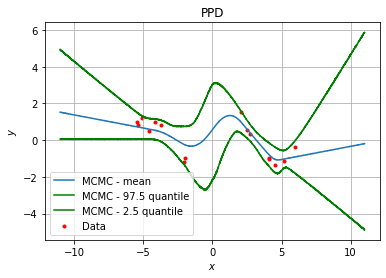

In [11]:
if use_mcmc:
    plt.plot(xx,samples_predictions_mean,label="MCMC - mean")
    plt.plot(xx,samples_predictions_97p5,color='g',label="MCMC - 97.5 quantile")
    #plt.plot(xx,samples_predictions_50p0,color='g',label="mcmc_50p0_quantile")
    plt.plot(xx,samples_predictions_2p5,color='g',label="MCMC - 2.5 quantile")
    plt.scatter(x,y, marker='.', color='r', label="Data")
    plt.legend()
    plt.grid()
    plt.ylabel(r"$y$")
    plt.xlabel(r"$x$")
    plt.title(r'PPD');

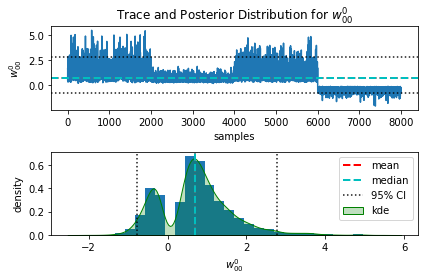

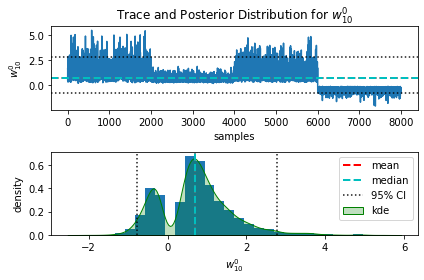

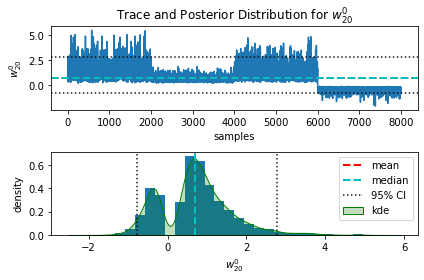

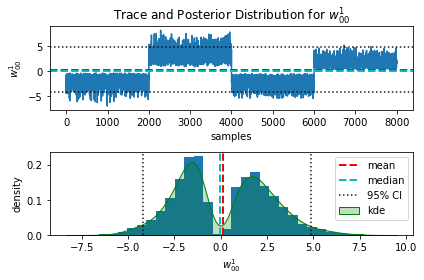

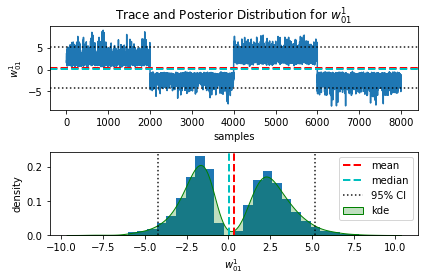

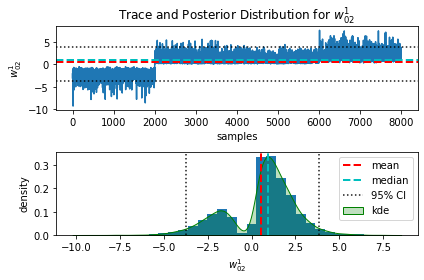

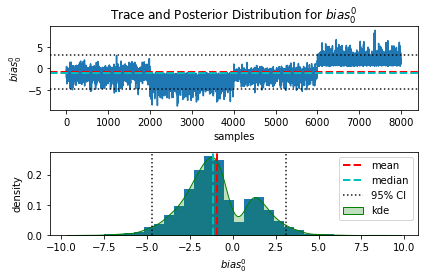

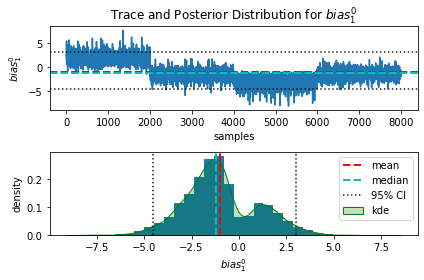

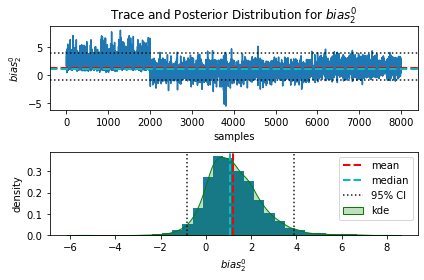

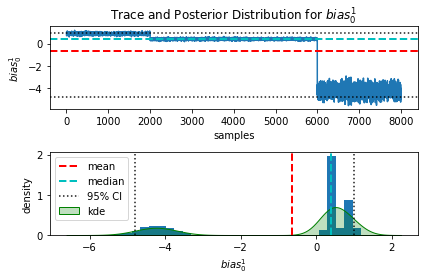

In [12]:
if use_mcmc:
    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_first'][:,0,0],r"$w^{0}_{"+str(i)+r"0}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['w_output'][:,i],r"$w^{1}_{0"+str(i)+r"}$")

    for i in range(num_hidden_units):
        plt.figure()
        plot_trace(fit_mcmc.extract()['bias_first'][:,i],r"$bias^{0}_{"+str(i)+r"}$")

    plt.figure()
    plot_trace(fit_mcmc.extract()['bias_output'],r"$bias^{1}_{0}$")

## Study initialization

In [13]:
num_runs=20

### functions

In [14]:
def get_lambdas_for_w(layer_weights, from_neuron_layer_bevore, to_neuron):
    """
        Gets the variational parameter for a specific weight
    """  
    try:
        num_param=14
        lambdas=[]
        
        for j in range(int(num_param)):
            lambdas.append(layer_weights[j][from_neuron_layer_bevore][to_neuron])
        return lambdas
    except:
        print("Constellation not existing")


def get_lambdas_for_bias(layer_weights, neuron):
    """
        Gets the variational parameter for a specific bias
    """  
    try:
        num_param=14
        lambdas=[]
 
        for j in range(num_param,num_param*2):
            lambdas.append(layer_weights[j][neuron])
        return lambdas
    except:
        print("Constellation not existing")

In [15]:
callbacks_VIGAUSS = [
    #callbacks.LearningRateScheduler(lr_scheduler, verbose=0)
]

class callback_save_weights(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # true
        if(epoch%subepochs==0):
            print("checkpoint:\t",int(epoch/subepochs),"\tloss:\t",logs["loss"])
            layer_weights=[]
            for layer in range(np.shape(self.model.layers)[0]):
                layer_weights.append(self.model.layers[layer].get_weights()[:])

            hist_weights.append(layer_weights)


callbacks_VIMLTS = [
        callback_save_weights()
]


# Number of checkpoints, to save the variational distribution during the training
checkpoints=50
subepochs=int(epochs/checkpoints)

### Variables to analyze

In [16]:
hist_loss_VIGAUSS_03=np.zeros([num_runs,epochs])
hist_nll_VIGAUSS_03=np.zeros([num_runs,epochs])
eval_nll_VIGAUSS_03=np.zeros([num_runs])

hist_loss_VIMLTS_03=np.zeros([num_runs,epochs])
hist_nll_VIMLTS_03=np.zeros([num_runs,epochs])
eval_nll_VIMLTS_03=np.zeros([num_runs])

## Study

In [17]:
for current_run in range(num_runs):
    x_in = Input(shape=(1,),name="VIGAUSS_il")
    x_arch = DenseVIGAUSS(units=num_hidden_units, activation='relu', kl_weight=kl_weight, name="VIGAUSS_hl_1", **prior_params )(x_in)
    x_arch = DenseVIGAUSS(units=1, kl_weight=kl_weight, name="VIGAUSS_ol", **prior_params)(x_arch)

    model_VIGAUSS = Model(x_in, x_arch,name="model_VIGAUSS")

    model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr,clipnorm=cn), metrics=[neg_log_likelihood])
    #model_VIGAUSS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr), metrics=[neg_log_likelihood])

    # Fit the model to the data
    hist=model_VIGAUSS.fit(x, y, callbacks=callbacks_VIGAUSS, batch_size=batch_size, epochs=epochs, verbose=0);

    x_in = Input(shape=(1,),name="VIMLTS_il")
    x_arch = DenseVIMLTS(units=num_hidden_units,
                        activation='relu', 
                        kl_weight=kl_weight, 
                        init_gauss_like=True,
                        using_f3=True,
                        name="VIMLTS_hl_1", **prior_params)(x_in)
    x_arch = DenseVIMLTS(units=1, 
                        kl_weight=kl_weight, 
                        init_gauss_like=True,
                        using_f3=True,
                        name="VIMLTS_ol", **prior_params)(x_arch)
    model_VIMLTS = Model(x_in, x_arch,name="model_VIMLTS")

    model_VIMLTS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr,clipnorm=cn), metrics=[neg_log_likelihood])
    #model_VIMLTS.compile(loss=neg_log_likelihood, optimizer=optimizers.Adam(lr=lr), metrics=[neg_log_likelihood])

    hist_weights=[]

    # Fit the model to the data
    hist_VIMLTS=model_VIMLTS.fit(x, y, callbacks=callbacks_VIMLTS, batch_size=batch_size, epochs=epochs, verbose=0)

    # Evaluate the model with the NLL
    VIGAUSS_NLL_test_list = []
    VIMLTS_NLL_test_list = []
    num_evaluations=20

    for i in range(num_evaluations):
        clear_output()
        print("round:\t",i,"/",num_evaluations)
        VIGAUSS_NLL_test_list.append(model_VIGAUSS.evaluate(x_test, y_test, batch_size=batch_size)[1])
        VIMLTS_NLL_test_list.append(model_VIMLTS.evaluate(x_test, y_test, batch_size=batch_size)[1])

    VIGAUSS_NLL_test_mean=np.mean(VIGAUSS_NLL_test_list)
    VIGAUSS_NLL_test_median=np.median(VIGAUSS_NLL_test_list)
    VIMLTS_NLL_test_mean=np.mean(VIMLTS_NLL_test_list)
    VIMLTS_NLL_test_median=np.median(VIMLTS_NLL_test_list)


    # Save the variables
    hist_loss_VIGAUSS_03[current_run][:]=hist.history['loss']
    hist_nll_VIGAUSS_03[current_run][:]=hist.history['neg_log_likelihood']
    eval_nll_VIGAUSS_03[current_run]=VIGAUSS_NLL_test_mean

    hist_loss_VIMLTS_03[current_run][:]=hist_VIMLTS.history['loss']
    hist_nll_VIMLTS_03[current_run][:]=hist_VIMLTS.history['neg_log_likelihood']
    eval_nll_VIMLTS_03[current_run]=VIMLTS_NLL_test_mean

round:	 19 / 20
1000/1000 [==============================] - 0s 390us/step


## Analyze the study

### Learning curves

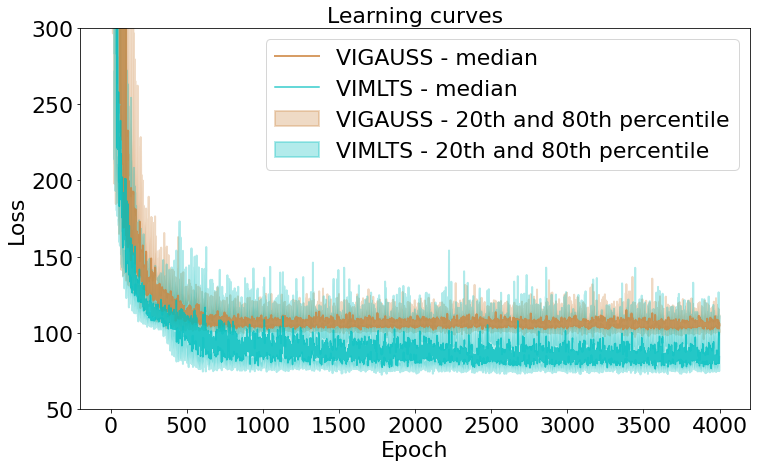

In [34]:
plt.figure(figsize=(12, 7))

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rc('axes', labelsize=22)
plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22)  
plt.rc('legend', fontsize=22) 

plt.rcParams['mathtext.fontset'] = 'cm'

linewidth=2

plt.plot(np.median(hist_loss_VIGAUSS_03,axis=0),color='peru',alpha=0.8,label=(r"VIGAUSS - median"),linewidth=linewidth)
plt.fill_between(x=range(epochs),y1=np.percentile(hist_loss_VIGAUSS_03,80,axis=0),y2=np.percentile(hist_loss_VIGAUSS_03,20,axis=0),color='peru', alpha=0.3, label=(r"VIGAUSS - 20th and 80th percentile"),linewidth=linewidth)

plt.plot(np.median(hist_loss_VIMLTS_03,axis=0),color='c',alpha=0.8,label=(r"VIMLTS - median"))
plt.fill_between(x=range(epochs),color='c',y1=np.percentile(hist_loss_VIMLTS_03,80,axis=0),y2=np.percentile(hist_loss_VIMLTS_03,20,axis=0), alpha=0.3,label=(r"VIMLTS - 20th and 80th percentile"),linewidth=linewidth)

plt.ylim([50,300])
plt.legend()
plt.title(r'Learning curves',fontsize=22)
plt.ylabel(r'Loss',fontsize=22)
plt.xlabel(r'Epoch',fontsize=22);

plt.savefig('output/bnn_ms_lc.svg', format='svg')
plt.savefig('output/bnn_ms_lc.pdf', format='pdf')

### NLL curves

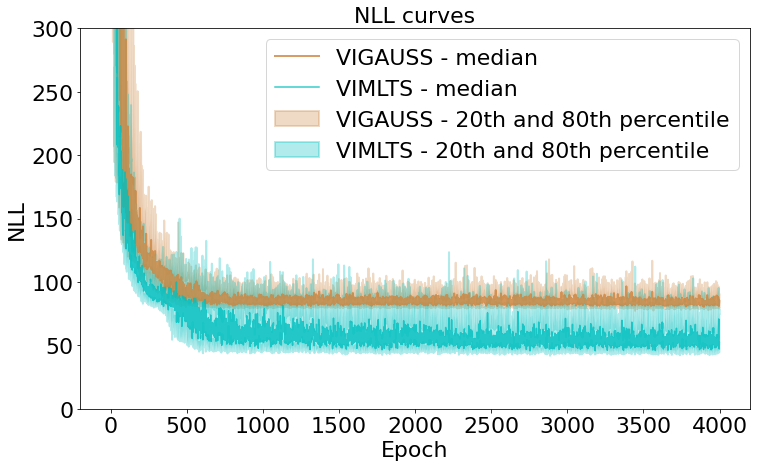

In [21]:
plt.figure(figsize=(12, 7)) 

plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rc('axes', labelsize=22)
plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22)  
plt.rc('legend', fontsize=22) 

plt.rcParams['mathtext.fontset'] = 'cm'

linewidth=2

plt.plot(np.median(hist_nll_VIGAUSS_03,axis=0),color='peru',alpha=0.8,label=(r"VIGAUSS - median"),linewidth=linewidth)
plt.fill_between(x=range(epochs),y1=np.percentile(hist_nll_VIGAUSS_03,80,axis=0),y2=np.percentile(hist_nll_VIGAUSS_03,20,axis=0),color='peru', alpha=0.3, label=(r"VIGAUSS - 20th and 80th percentile"),linewidth=linewidth)

plt.plot(np.median(hist_nll_VIMLTS_03,axis=0),color='c',alpha=0.8,label=(r"VIMLTS - median"))
plt.fill_between(x=range(epochs),color='c',y1=np.percentile(hist_nll_VIMLTS_03,80,axis=0),y2=np.percentile(hist_nll_VIMLTS_03,20,axis=0), alpha=0.3,label=(r"VIMLTS - 20th and 80th percentile"),linewidth=linewidth)

plt.ylim([0,300])
plt.legend()
plt.title(r'NLL curves',fontsize=22)
plt.ylabel(r'NLL',fontsize=22)
plt.xlabel(r'Epoch',fontsize=22);

plt.savefig('output/bnn_ms_nllc.svg', format='svg')
plt.savefig('output/bnn_ms_nllc.pdf', format='pdf')

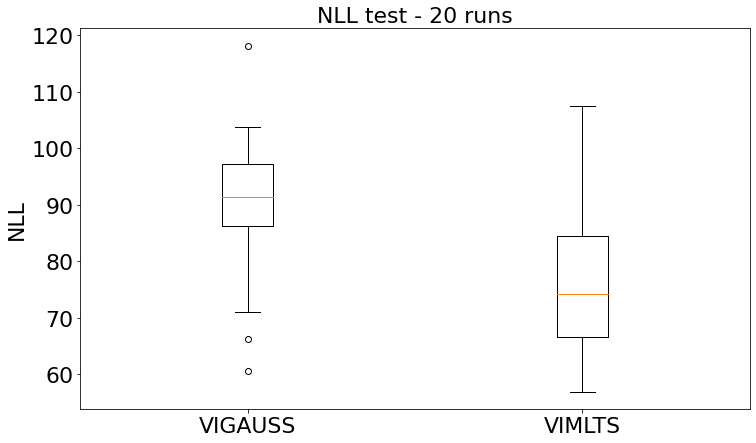

In [22]:
# Boxplot NLL
plt.figure(figsize=(12, 7)) #single
plt.rc('xtick', labelsize=22) 
plt.rc('ytick', labelsize=22)
plt.rc('axes', labelsize=22)
plt.rc('figure', titlesize=22)
plt.rc('axes', titlesize=22)  
plt.rc('legend', fontsize=22) 
plt.rcParams['mathtext.fontset'] = 'cm'
linewidth=2

plt.boxplot([eval_nll_VIGAUSS_03,eval_nll_VIMLTS_03],labels=["VIGAUSS", "VIMLTS"]);

plt.ylabel(r'NLL')
plt.title(r'NLL test - 20 runs')

plt.savefig('output/bnn_ms_bp_nll.svg', format='svg')
plt.savefig('output/bnn_ms_bp_nll.pdf', format='pdf')

# Save the variables

In [24]:
import pandas as pd
import pickle

In [31]:
df_03_study_eval_nll=pd.DataFrame()
df_03_study_eval_nll['eval_nll_VIGAUSS_03']=eval_nll_VIGAUSS_03
df_03_study_eval_nll['eval_nll_VIMLTS_03']=eval_nll_VIMLTS_03

In [32]:
pickle.dump( hist_VIMLTS, open( "df_03_study_hist_vimlts.p", "wb" ) )
pickle.dump( hist, open( "df_03_study_hist_vigauss.p", "wb" ) )
pickle.dump( df_03_study_eval_nll, open( "df_03_study_eval_nll.p", "wb" ) )